<b> Name : Anish Rajesh Adnani
    <br>
USC ID : 4092610491
    <br>
USC Email ID : adnani@usc.edu
    <br>
Github Username : midnightbot</b>

In [1]:
## all imports
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Input, Dense
from tensorflow.keras.models import Model
from keras import optimizers
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import glob
import shutil
import splitfolders
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from skimage import io
import Augmentor
from tensorflow.keras import activations
from tensorflow.keras.layers import Dropout
import tensorflow
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Activation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import warnings
import math
import random
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from tensorflow.keras.preprocessing import image_dataset_from_directory
warnings.filterwarnings('ignore')
%matplotlib inline

<b> 1. Transfer Learning for Image Classification </b>

<b> 1.(a) In this problem, we are trying to build a classifier that distinguishes images of 20 bird species. You are provided with text data in twenty folders</b>

<b> 1.(b) Data Exploration and Pre-processing</b>

<b> 1.(b) (i) Images in each class are given in separate folders. The file Classes.xlsx pro- vides the classes assigned to the bird species images in each folder. Therefore, you encode your classes using one-hot encoding and Classes.xlsx .</b>

In [2]:
## there are 20 classes hence one-hot encoding will be as follows
class_file_location = "../data/Classes.xlsx"
classes = pd.read_excel(class_file_location)
display(classes)

,Folder Name,Class
0,005.Crested_Auklet,0
1,013.Bobolink,1
2,015.Lazuli_Bunting,2
3,023.Brandt_Cormorant,3
4,040.Olive_sided_Flycatcher,4
5,041.Scissor_tailed_Flycatcher,5
6,067.Anna_Hummingbird,6
7,072.Pomarine_Jaeger,7
8,076.Dark_eyed_Junco,8
9,081.Pied_Kingfisher,9


In [3]:
class_rep = {}
for it, rows in classes.iterrows():
    zeros = [0 for x in range(20)]
    zeros[int(rows['Class'])] = 1
    class_rep[rows['Folder Name ']] = zeros

In [4]:
data_location = '../data/images'
all_folders = [f.path for f in os.scandir(data_location)]
all_folders = sorted(all_folders)
print(all_folders)

['../data/images/005.Crested_Auklet', '../data/images/013.Bobolink', '../data/images/015.Lazuli_Bunting', '../data/images/023.Brandt_Cormorant', '../data/images/040.Olive_sided_Flycatcher', '../data/images/041.Scissor_tailed_Flycatcher', '../data/images/067.Anna_Hummingbird', '../data/images/072.Pomarine_Jaeger', '../data/images/076.Dark_eyed_Junco', '../data/images/081.Pied_Kingfisher', '../data/images/082.Ringed_Kingfisher', '../data/images/086.Pacific_Loon', '../data/images/099.Ovenbird', '../data/images/104.American_Pipit', '../data/images/127.Savannah_Sparrow', '../data/images/135.Bank_Swallow', '../data/images/141.Artic_Tern', '../data/images/149.Brown_Thrasher', '../data/images/156.White_eyed_Vireo', '../data/images/168.Kentucky_Warbler']


<b> 1.(b) (ii) Randomly select d 0 . 7 n i e images from each folder as your training set, d 0 . 15 n i e as validation set, and the rest as your test set, where n i is the number of images in folder i and d x e is the ceiling of x</b>

In [5]:
##splitfolders.ratio(data_location, output='../data/dataset', ratio=(0.7,0.15,0.15), group_prefix=None)

## making a copy of og dataset
## keeping a copy of original data
shutil.copytree('../data/images', '../data/og_data')
## train, validation, test folder creation

for flds in all_folders:
    if flds == '../data/images/.DS_Store':
        continue
    cls_name = flds.split("/")[-1]
    path = '../data/dataset/'
    os.makedirs(os.path.join(path+'train/',cls_name))
    os.makedirs(os.path.join(path+'test/',cls_name))
    os.makedirs(os.path.join(path+'val/',cls_name))

for flds in all_folders:
    if flds == '../data/images/.DS_Store':
        continue
    total_images = len([f.path for f in os.scandir(flds)])
    train_img_count = math.ceil(total_images*0.7)
    val_img_count = math.ceil(total_images*0.15)
    test_img_count = total_images - train_img_count - val_img_count
    cls_name = flds.split("/")[-1]
    
    ## train images
    train_images = random.sample(os.listdir(flds), train_img_count)
    for i in train_images:
        shutil.move(flds+"/"+i, '../data/dataset/train/'+cls_name+"/"+i)
        
    ## validation images
    val_images = random.sample(os.listdir(flds), val_img_count)
    for i in val_images:
        shutil.move(flds+"/"+i, '../data/dataset/val/'+cls_name+"/"+i) 
        
    ## test images
    test_images = random.sample(os.listdir(flds), test_img_count)
    for i in test_images:
        shutil.move(flds+"/"+i, '../data/dataset/test/'+cls_name+"/"+i) 
    

<b> 1.(b)(iii) In order for all the images to have the same size, zero-pad or resize the images
in your dataset. This can be done using various tools, including OpenCV</b>

In [6]:
## resizing all images to (224,224)
base_folder = '../data/dataset/'

def resize_all_images(folder_name):
    location = base_folder + folder_name
    all_folders = [f.path for f in os.scandir(location)]
    for fld in all_folders:
        all_imgs = [f.path for f in os.scandir(fld)]
        for imgs in all_imgs:
            im = cv2.imread(imgs)
            im_resize = cv2.resize(im, (224,224))
            os.remove(imgs)
            cv2.imwrite(imgs, im_resize)
            
resize_all_images('train')
resize_all_images('val')
resize_all_images('test')

In [7]:
train_set = image_dataset_from_directory('../data/dataset/train', image_size=(224,224), labels='inferred', label_mode='categorical')

val_set = image_dataset_from_directory('../data/dataset/val', image_size=(224,224), labels='inferred', label_mode='categorical')

Found 827 files belonging to 20 classes.
Metal device set to: Apple M1 Pro
Found 178 files belonging to 20 classes.


2022-12-12 16:54:10.610078: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 16:54:10.610247: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<b> 1.(c) Transfer Learning</b>

<b> 1.(c)(i) When dealing with classification of relatively small image datasets, deep net- works may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning , which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those fea- tures can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement lay- ers. The dataset in this task has only around 50-60 images per class. Given that we have 20 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained mod- els EfficientNetB0 and VGG16 . For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image</b>

<b> 1.(c)(ii) To perform empirical regularization, crop, randomly zoo, rotate, flip, contrast,
and translate images in your training set for image augmentation. You can
use various tools to do this, including OpenCV</b>

In [8]:
image_augmentation = keras.Sequential([
    layers.Cropping2D((33,33)),
    layers.RandomZoom(0.5, 0.2),
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
], name='augmentation')

<b> 1.(c) (iii) Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 4 and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.</b>

<b> 1.c.(iv) Train the networks ( EfficientNetB0 and VGG16 ) for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs </b>

In [10]:
## preparing vgg16 model with image augmentation and early stopping
inputs = layers.Input(shape=(224,224,3))
x = image_augmentation(inputs)
x = tensorflow.keras.applications.vgg16.preprocess_input(x)

model = VGG16(weights="imagenet", input_tensor=x, include_top=False)
model.trainable = False

x = layers.GlobalAveragePooling2D(name="avg_pooling")(model.output)
x = layers.BatchNormalization()(x)

layer1 = Dense(20)(x)
layer1_1 = BatchNormalization()(layer1)
layer1_2 = Activation('relu')(layer1_1)
layer1_3 = Dropout(0.2)(layer1_2)

layer2 = Dense(20)(layer1_3)
op = Activation('softmax')(layer2)

vgg_model_es = tensorflow.keras.Model(inputs, op, name="vgg_v3")
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=1e-2)
metrics = ['accuracy', tensorflow.keras.metrics.Precision(), tensorflow.keras.metrics.Recall()]

vgg_model_es.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=10,
                                                          min_delta = 0.01,
                                                          mode ="min",
                                                          verbose=1,
                                                          restore_best_weights=True)

vgg_model_history = vgg_model_es.fit(train_set, 
                 epochs=100, 
                 validation_data=val_set, 
                 verbose=1, 
                 batch_size=5,
                 callbacks=[early_stopping])

Epoch 1/100


2022-12-12 16:54:24.164355: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-12 16:54:24.169390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - ETA: 0s - loss: 2.6285 - accuracy: 0.4414 - precision: 0.5235 - recall: 0.3906

2022-12-12 16:54:48.842767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 27s 947ms/step - loss: 2.6285 - accuracy: 0.4414 - precision: 0.5235 - recall: 0.3906 - val_loss: 8.4329 - val_accuracy: 0.6461 - val_precision: 0.6497 - val_recall: 0.6461
Epoch 2/100
26/26 [==============================] - 24s 904ms/step - loss: 1.2423 - accuracy: 0.6626 - precision: 0.7245 - recall: 0.6264 - val_loss: 4.7199 - val_accuracy: 0.6910 - val_precision: 0.6932 - val_recall: 0.6854
Epoch 3/100
26/26 [==============================] - 24s 929ms/step - loss: 0.9206 - accuracy: 0.7461 - precision: 0.7989 - recall: 0.7110 - val_loss: 3.5359 - val_accuracy: 0.7303 - val_precision: 0.7386 - val_recall: 0.7303
Epoch 4/100
26/26 [==============================] - 24s 921ms/step - loss: 0.8524 - accuracy: 0.7449 - precision: 0.8072 - recall: 0.7086 - val_loss: 2.4634 - val_accuracy: 0.7584 - val_precision: 0.7644 - val_recall: 0.7472
Epoch 5/100
26/26 [==============================] - 24s 919ms/step - loss: 0.6997 - accuracy: 0.7739 - prec

In [12]:
test_set = image_dataset_from_directory('../data/dataset/test', image_size=(224,224), labels='inferred', label_mode='categorical')
test_ans = vgg_model_es.evaluate(test_set)

Found 171 files belonging to 20 classes.
6/6 [==============================] - 1s 143ms/step - loss: 0.9890 - accuracy: 0.8363 - precision: 0.8443 - recall: 0.8246


In [13]:
train_ans = vgg_model_es.evaluate(train_set)

26/26 [==============================] - 4s 138ms/step - loss: 0.2364 - accuracy: 0.9492 - precision: 0.9537 - recall: 0.9456


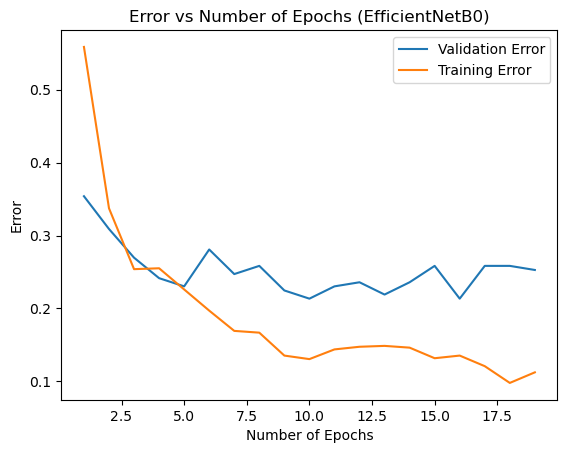

In [15]:
x_axis = [x for x in range(1,len(vgg_model_history.history['val_loss'])+1)]
plt.plot(x_axis, [1-x for x in vgg_model_history.history['val_accuracy']], label='Validation Error')
plt.plot(x_axis, [1-x for x in vgg_model_history.history['accuracy']], label='Training Error')
plt.xlabel("Number of Epochs")
plt.ylabel("Error")
plt.title("Error vs Number of Epochs (EfficientNetB0)")
plt.legend()

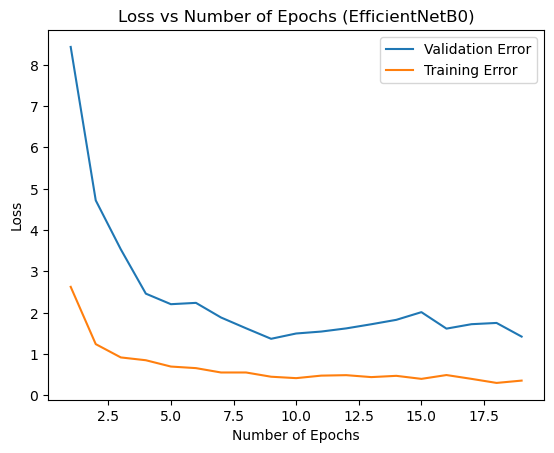

In [26]:
x_axis = [x for x in range(1,len(vgg_model_history.history['val_loss'])+1)]
plt.plot(x_axis, [x for x in vgg_model_history.history['val_loss']], label='Validation Error')
plt.plot(x_axis, [x for x in vgg_model_history.history['loss']], label='Training Error')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of Epochs (EfficientNetB0)")
plt.legend()

<b> 1.(c)(v) Report Precision, Recall, and F1 score for your model. Remember that this
is a multi-class classification problem.</b>

In [17]:
## vgg precision recall
folder = "../data/dataset/test"
all_test_folders = [f.path for f in os.scandir(folder)]
all_test_folders = sorted(all_test_folders) ## image_dataset_from_directory gives class number in ascending order
c = 0
dicts = {}
for it in all_test_folders:
    s = it.split("/")[-1]
    dicts[s] = c
    c+=1
actual_test_vgg = []
preds_test_vgg = []

for it in all_test_folders:
    if it=='../data/dataset/test/.DS_Store':
        continue
    all_imgs = [f.path for f in os.scandir(it)]
    this_class = it.split("/")[-1]
    this_class = dicts[this_class]
    for i in all_imgs:
        img = tensorflow.keras.utils.load_img(i, target_size=(224,224,3))
        img_array = tensorflow.keras.utils.img_to_array(img)
        img_array = tensorflow.expand_dims(img_array,0)
        
        pred_class = vgg_model_es.predict(img_array)
        pred_class = np.argmax(pred_class)
        preds_test_vgg.append(pred_class)
        actual_test_vgg.append(this_class)

2022-12-12 17:03:18.299103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step


In [18]:
print("Classification Report Test Data VGG16")
print(classification_report(actual_test_vgg, preds_test_vgg))

Classification Report Test Data VGG16
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.89      0.94         9
           2       0.89      1.00      0.94         8
           3       0.88      0.88      0.88         8
           4       0.78      0.78      0.78         9
           5       1.00      0.89      0.94         9
           6       0.89      0.89      0.89         9
           7       1.00      0.89      0.94         9
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         9
          10       0.89      0.89      0.89         9
          11       0.89      0.89      0.89         9
          12       0.46      0.67      0.55         9
          13       0.80      0.44      0.57         9
          14       0.78      0.78      0.78         9
          15       0.64      0.88      0.74         8
          16       1.00      1.00      1.00

In [19]:
precision,recall,fscore,support=score(actual_test_vgg,preds_test_vgg,average='macro')

In [20]:
## vgg precision recall
folder = "../data/dataset/train"
all_test_folders = [f.path for f in os.scandir(folder)]
all_test_folders = sorted(all_test_folders) ## image_dataset_from_directory gives class number in ascending order
c = 0
dicts = {}
for it in all_test_folders:
    s = it.split("/")[-1]
    dicts[s] = c
    c+=1
actual_train_vgg = []
preds_train_vgg = []

for it in all_test_folders:
    if it=='../data/dataset/test/.DS_Store':
        continue
    all_imgs = [f.path for f in os.scandir(it)]
    this_class = it.split("/")[-1]
    this_class = dicts[this_class]
    for i in all_imgs:
        img = tensorflow.keras.utils.load_img(i, target_size=(224,224,3))
        img_array = tensorflow.keras.utils.img_to_array(img)
        img_array = tensorflow.expand_dims(img_array,0)
        
        pred_class = vgg_model_es.predict(img_array)
        pred_class = np.argmax(pred_class)
        preds_train_vgg.append(pred_class)
        actual_train_vgg.append(this_class)

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


In [21]:
print("Classification Report Train Data VGG16")
print(classification_report(actual_train_vgg, preds_train_vgg))

Classification Report Train Data VGG16
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      0.90      0.95        42
           2       0.95      1.00      0.98        41
           3       0.93      0.95      0.94        42
           4       0.95      0.88      0.91        42
           5       0.97      0.88      0.93        42
           6       0.95      1.00      0.98        42
           7       0.89      1.00      0.94        42
           8       1.00      0.93      0.96        42
           9       1.00      0.98      0.99        42
          10       0.98      1.00      0.99        42
          11       1.00      0.88      0.94        42
          12       0.82      0.98      0.89        42
          13       1.00      0.93      0.96        42
          14       0.95      0.88      0.91        42
          15       0.82      1.00      0.90        42
          16       0.98      1.00      0.9

In [22]:
precision_train,recall_train,fscore_train,support_train=score(actual_train_vgg,preds_train_vgg,average='macro')

In [23]:
final_cols = ["", "Precision", "Recall", "F Score", "Loss", "Accuracy"]
final_rows = []
final_rows.append(["VGG16_TEST", precision, recall, fscore, test_ans[0], test_ans[1]])
final_rows.append(["VGG16_TRAIN", precision_train, recall_train, fscore_train, train_ans[0], train_ans[1]])

In [24]:
final_df = pd.DataFrame(data=final_rows, columns=final_cols)

In [25]:
display(final_df)

,,Precision,Recall,F Score,Loss,Accuracy
0,VGG16_TEST,0.867812,0.847917,0.842841,0.989034,0.836257
1,VGG16_TRAIN,0.954654,0.950000,0.950113,0.236403,0.949214
